Binned acquisition
==================

In this tutorial we will demonstrate the sequencer based acquisition binning procedure. The binning process is applied on the input path
after real-time demodulation, (weighed) integration, IQ rotation and discretization. It allows storing both the integration and discretization
results on the fly without intervention of the host PC in up to 131072 bins. It also allows averaging those bins on the fly as well (see section [Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#acquisitions)). We will show this by using a QRM and directly connecting outputs 
$\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$ respectively. We will then use the QRM's sequencers to sequence waveforms on 
the outputs and simultaneously acquire the resulting waveforms on the inputs.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable -–py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Device",
)
print(
    "The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on."
)
display(connect)

The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on.


Dropdown(description='Select Device', options=('cluster-mm',), value='cluster-mm')

#### Pulsar QRM <a id='pulsar_setup'></a>
Choose the Pulsar QRM, run the following cell. Skip to the [Cluster QRM section](#cluster_setup) if you selected a Cluster module.

In [3]:
# Close existing connections to the Pulsar modules
Pulsar.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# Connect to device and reset
qrm = Pulsar(f"{device_name}", ip_address)
qrm.reset()
print(f"{device_name} connected at {ip_address}")
print(qrm.get_system_state())

pulsar-qrm connected at 192.168.0.4
Status: OKAY, Flags: NONE, Slot flags: NONE


Skip to [Generate Waveform and Weights](#gen_wf) if you have not selected a Cluster module.

#### Cluster QRM <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar QRM section](#pulsar_setup) if you are using a Pulsar.


In [3]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

cluster-mm connected at 192.168.0.2


We then find all available cluster modules to connect to them individually.

In [6]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

# List of all QxM modules present
connect_qxm = widgets.Dropdown(options=[key for key in available_slots.keys()])

print(available_slots)
# display widget with cluster modules
print()
print("Select the QRM module from the available modules in your Cluster:")
display(connect_qxm)

{'module2': 'QCM', 'module4': 'QRM', 'module6': 'QCM-RF', 'module8': 'QRM-RF'}

Select the QRM module from the available modules in your Cluster:


Dropdown(options=('module2', 'module4', 'module6', 'module8'), value='module2')

Finally, we connect to the selected Cluster module. 

In [7]:
# Connect to the cluster QRM
qrm = getattr(
    cluster, connect_qxm.value
)  # Connect to the module that you have chosen above
print(f"{available_slots[connect_qxm.value]} connected")
print(cluster.get_system_state())

QRM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms and weights<a id='gen_wf'></a>
------------------------------

Next, we need to create the waveforms used by the sequence for playback on the outputs as well as weights used by the sequence for weighed
integrations.To keep it straightforward, we use the DC offset from the sequencers as our waveforms and define waveform weights in the cell
below.

In [4]:
# Waveform and weight parameters
waveform_weight_length = 600  # nanoseconds

# These will be used as weights in the "Weighed acquisition" section
waveforms_weights = {
    "gaussian": {
        "data": scipy.signal.gaussian(
            waveform_weight_length, std=0.12 * waveform_weight_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_weight_length) * i)
            for i in range(0, waveform_weight_length)
        ],
        "index": 1,
    },
    "block": {"data": [1.0 for _ in range(0, waveform_weight_length)], "index": 2},
}

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create 4 acquisition specifications that each create multiple bins.

In [5]:
# Acquisitions
acquisitions = {
    "non_weighed": {"num_bins": 10, "index": 0},
    "weighed": {"num_bins": 10, "index": 1},
    "large": {"num_bins": 131072, "index": 2},
    "avg": {"num_bins": 10, "index": 3},
}

Create Q1ASM program
--------------------

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions.
In this case we will simply trigger 10 non-weighed acquisitions and store each acquisition in a separate bin.

In [6]:
# Sequence program.
seq_prog = """
      move    0,R0        #Loop iterator.
      nop

loop: acquire 0,R0,1200   #Acquire bins and store them in "non_weighed" acquisition.
      add     R0,1,R0     #Increment iterator
      nop                 #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop #Run until number of iterations is done.

      stop                #Stop.
"""

Upload sequence
---------------

Now that we have the waveform, weights and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [7]:
# Add sequence program, waveforms, weights and acquistitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [8]:
# Upload sequence.
qrm.sequencer0.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers. To keep it simple we will set a DC signal on the outputs of the instrument by enabling the sequencer offsets and disabling the modulation. These DC signals will then be acquired through the inputs, so we will also disable the demodulation on the input path. Furthermore, since we are running non-weighed integrations we need to specify the integration length. This integration length will be used for every non-weighed integration moving forward. We will also put the integration result phase rotation to 0 degrees and discretation threshold to 0.

In [9]:
# Configure scope mode
qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer
qrm.sequencer0.offset_awg_path0(0.5)
qrm.sequencer0.offset_awg_path1(0.5)
qrm.sequencer0.mod_en_awg(False)
qrm.sequencer0.demod_en_acq(False)
qrm.sequencer0.integration_length_acq(1000)
qrm.sequencer0.thresholded_acq_rotation(0)
qrm.sequencer0.thresholded_acq_threshold(0)

# Map sequencer to specific outputs (but first disable all sequencer connections)
for sequencer in qrm.sequencers:
    for out in range(0, 2):
        sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)
qrm.sequencer0.channel_map_path0_out0_en(True)
qrm.sequencer0.channel_map_path1_out1_en(True)

Now let's start the sequence.

In [10]:
# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Print status of sequencer.
print(qrm.get_sequencer_state(0, 1))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Retrieve acquisition
--------------------

Next we will have a quick look at the input signal, so that we can compare it to the integration results. Since we are integrating over a DC signal we are expecting the integration results to be roughly equal to the average DC value.

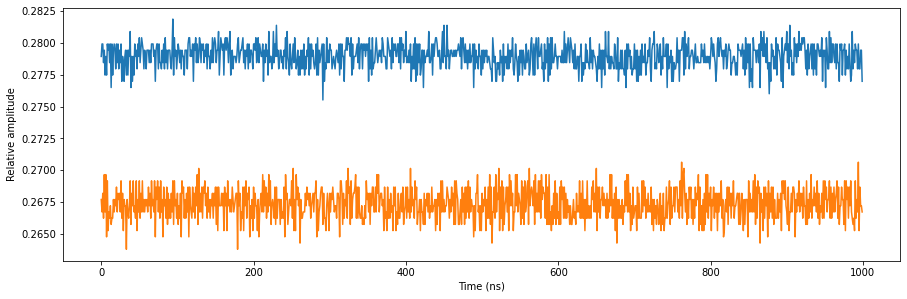

In [11]:
# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "non_weighed")

# Get acquisition list from instrument.
non_weighed_acq = qrm.get_acquisitions(0)["non_weighed"]

# Plot acquired signal on both inputs.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(non_weighed_acq["acquisition"]["scope"]["path0"]["data"][0:1000])
ax.plot(non_weighed_acq["acquisition"]["scope"]["path1"]["data"][0:1000])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

To check if the integration results match with what we expect, we need to divide the integration results by the integration length which was set through the 
corresponding QCoDeS parameter. Note that the 'valid' key of the dictionary indicates if the bin was actually set during the sequence.

In [12]:
int_len = qrm.sequencer0.integration_length_acq()
bins = non_weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.27915486077186125,
   0.2791612115290669,
   0.27915192965315094,
   0.27901367855398146,
   0.2791001465559355,
   0.2791299462628236,
   0.2789799706888129,
   0.2790600879335613,
   0.279057156814851,
   0.27897557401074746],
  'path1': [0.2676213971665853,
   0.26770151441133366,
   0.2676560820713239,
   0.26742061553492913,
   0.2675017098192477,
   0.26750122129946263,
   0.2674181729360039,
   0.26754714215925746,
   0.26734391792867607,
   0.26737909135319976]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Weighed acquisition
-------------------

Next we will show weighed integrations. To do this, we will need to modify the sequence program slightly and reupload the program. We will be using a the gaussian weight to integrate over input path 0 and the sine weight to integrate over input path 1. The integration length of a weighed integration is determined by the weight length. 

In [13]:
# Sequence program.
seq_prog = """
      move            0,R0            #Loop iterator.
      move            0,R1            #Weight for path 0.
      move            1,R2            #Weight for path 1.
      nop

loop: acquire_weighed 1,R0,R1,R2,1200 #Acquire bins and store them in "weighed" acquisition.
      add             R0,1,R0         #Increment iterator
      nop                             #Wait a cycle for R0 to be available.
      jlt             R0,10,@loop     #Run until number of iterations is done.

      stop                            #Stop.
"""

In [14]:
# Add sequence program, waveforms, weights and acquistitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [15]:
# Upload sequence.
qrm.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [16]:
# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Print status of sequencer.
print(qrm.get_sequencer_state(0, 1))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [17]:
# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Get acquisition list from instrument.
weighed_acq = qrm.get_acquisitions(0)["weighed"]

To check if the integration results match with what we expect, we need to divide the integration results by the integration length again. In this case the integration
length is determined by the length of the weights.

In [18]:
int_len = waveform_weight_length
bins = weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.0838375615631583,
   0.08379245402794945,
   0.0838248975170451,
   0.08380893490833831,
   0.08373342157077765,
   0.0837548154917014,
   0.08381608371642879,
   0.08383202245997753,
   0.08376547844431308,
   0.08379022621544653],
  'path1': [-5.6059653985437636e-05,
   -3.018027660831874e-05,
   3.383960084091271e-05,
   6.327051148681764e-06,
   -1.1236511909867344e-06,
   1.715626436135604e-05,
   -0.00011699814177924457,
   -5.624102918653143e-05,
   -3.3345592069512524e-05,
   -0.00010118747457863478]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Large number of bins
--------------------

The QRM supports up to 131072 bins. To show that, we need to change the program slightly again. We will use the non-weighed acquisition program,
but now we will loop over the maximum number of acquisitions while storing each result in a separate bin.

In [19]:
# Sequence program.
seq_prog = """
      move    0,R0            #Loop iterator.
      nop

loop: acquire 2,R0,1200       #Acquire bins and store them in "large" acquisition.
      add     R0,1,R0         #Increment iterator
      nop                     #Wait a cycle for R0 to be available.
      jlt     R0,131072,@loop #Run until number of iterations is done.

      stop                    #Stop.
"""

In [20]:
# Add sequence program, waveforms, weights and acquistitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [21]:
# Upload sequence.
qrm.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [22]:
# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Print status of sequencer.
print(qrm.get_sequencer_state(0, 1))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [23]:
# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Get acquisition list from instrument.
large_acq = qrm.get_acquisitions(0)["large"]

Since the number of bins is now to large to simply print, we will check the number of bins and we will check the bins for NaN values which indicate that a bin is not written. 

In [24]:
int_len = qrm.sequencer0.integration_length_acq()
bins = large_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]

print("Number of bins: {}".format(len(bins["avg_cnt"])))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        Exception("NaN found at index {}.".format(it))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        Exception("NaN found at index {}.".format(it))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        Exception("NaN found at index {}.".format(it))
print("All values are valid.")

Number of bins: 131072
All values are valid.


We will also plot the integration results in every bin to visualize the contents.

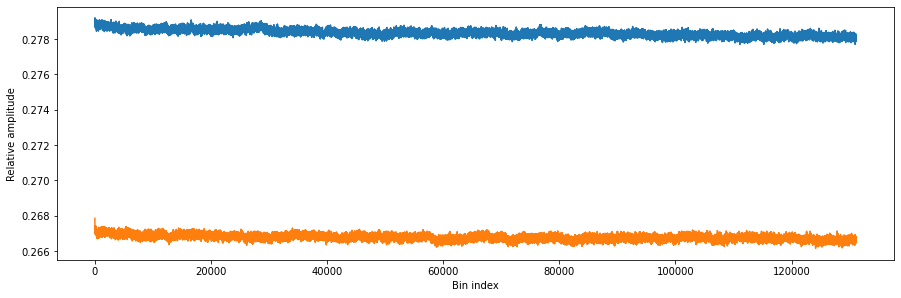

In [25]:
# Plot bins
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(bins["integration"]["path0"])
ax.plot(bins["integration"]["path1"])
ax.set_xlabel("Bin index")
ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

Averaging
--------------------

As you might have noticed, the acquisition results also contain an average counter. This average counter reflects the number of times a bin as been averaged during the sequence.
Each time a the sequence writes to the same bin the results are automatically accumulated and the average counter is increased. Upon retrieval of the acquisition results, each
result is divided by the average counter and therefore automatically averaged. To show this, we will change the sequence one last time. This time we will average 10 bins a 1000
times each.

In [26]:
# Sequence program.
seq_prog = """
      move    0,R1         #Average iterator.

avg:  move    0,R0         #Bin iterator.
      nop

loop: acquire 3,R0,1200    #Acquire bins and store them in "avg" acquisition.
      add     R0,1,R0      #Increment bin iterator
      nop                  #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop  #Run until number of avg iterations is done.
      add     R1,1,R1      #Increment avg iterator
      nop                  #Wait a cycle for R1 to be available.
      jlt     R1,1000,@avg #Run until number of average iterations is done.

      stop                 #Stop.
"""

In [27]:
# Add sequence program, waveforms, weights and acquistitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [28]:
# Upload sequence.
qrm.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [29]:
# Arm and start sequencer.
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Print status of sequencer.
print(qrm.get_sequencer_state(0, 1))

Status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Note that the average count of each bin is now set to a 1000.

In [30]:
# Wait for the sequencer to stop with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Get acquisition list from instrument.
avg_acq = qrm.get_acquisitions(0)["avg"]

In [31]:
int_len = qrm.sequencer0.integration_length_acq()
bins = avg_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.2783555486077186,
   0.2783564631167562,
   0.2783504118221788,
   0.2783517176355642,
   0.27834840449438203,
   0.27835067464582314,
   0.2783542623351246,
   0.2783474118221788,
   0.2783547987298486,
   0.2783543351245726],
  'path1': [0.26682932535417686,
   0.2668245642403517,
   0.26682411724474836,
   0.2668218031265267,
   0.2668268925256473,
   0.26682839179286766,
   0.2668272222765022,
   0.2668283277967758,
   0.2668281695163654,
   0.2668296311675623]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]}

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop sequencer.
qrm.stop_sequencer()

# Print status of sequencer.
print(qrm.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# qrm.print_readable_snapshot(update=True)

# Close the instrument connection.
Pulsar.close_all()
Cluster.close_all()